SIMPLE LINEAR REGRESSION:
Training R²: 0.8282, RMSE: 30.66
Test R²: 0.7429, RMSE: 18.86
Equation: IDM = 0.854 × DAM + 8.21


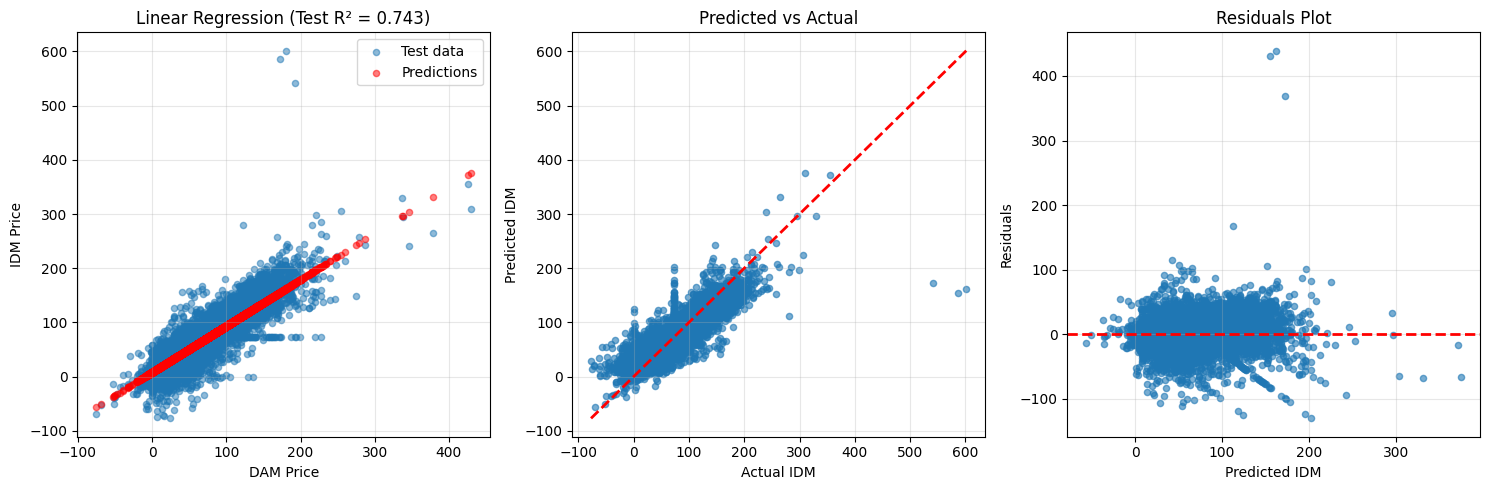

In [55]:
'''Simple Linear Regression Model'''

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Load data
df = pd.read_csv('cleaned_DAM_IDM_data.csv')
df['Date (UK)'] = pd.to_datetime(df['Date (UK)'])

# Filter data from 2015 to 2024 and sort by date
df_filtered = df[(df['Date (UK)'].dt.year >= 2015) & (df['Date (UK)'].dt.year <= 2024)].sort_values('Date (UK)')

# Prepare features and targets
X = df_filtered[['DAM price']].values
y = df_filtered['IDM price'].values

# Chronological 80:20 split (same as autoregressive models)
split_idx = int(len(df_filtered) * 0.8)
X_train = X[:split_idx]
X_test = X[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("SIMPLE LINEAR REGRESSION:")
print("=" * 50)
print(f"Training R²: {train_r2:.4f}, RMSE: {train_rmse:.2f}")
print(f"Test R²: {test_r2:.4f}, RMSE: {test_rmse:.2f}")
print(f"Equation: IDM = {model.coef_[0]:.3f} × DAM + {model.intercept_:.2f}")

# Plot
plt.figure(figsize=(15, 5))

# Scatter plot with regression line
plt.subplot(1, 3, 1)
plt.scatter(X_test, y_test, alpha=0.5, label='Test data', s=20)
plt.scatter(X_test, y_test_pred, alpha=0.5, label='Predictions', s=20, color='red')
plt.xlabel('DAM Price')
plt.ylabel('IDM Price')
plt.title(f'Linear Regression (Test R² = {test_r2:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Predicted vs Actual
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_test_pred, alpha=0.6, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual IDM')
plt.ylabel('Predicted IDM')
plt.title('Predicted vs Actual')
plt.grid(True, alpha=0.3)

# Residuals plot
plt.subplot(1, 3, 3)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.6, s=20)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted IDM')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [56]:
'''Figure 22 - Autoregressive with LASSO - Comprehensive Feature Exploration'''
# DAM + Multiple IDM lags (24-72h) + Calendar features + Moving averages (7-day & 14-day)

import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("Figure 22: COMPREHENSIVE LASSO MODEL FOR FEATURE EXPLORATION")
print("=" * 80)
print("Candidate Variables:")
print("  - DAM price (1 feature)")
print("  - IDM lags: 24-72 hours (49 features)")
print("  - Calendar: hour, day_of_week, is_weekend, month (4 features)")
print("  - Moving averages: 7-day, 14-day (2 features)")
print("  - Total: 56 candidate features")
print("=" * 80)

# Load and prepare data
df = pd.read_csv('cleaned_DAM_IDM_data.csv')
df['Date (UK)'] = pd.to_datetime(df['Date (UK)'])
df_filtered = df[(df['Date (UK)'].dt.year >= 2015) & 
                  (df['Date (UK)'].dt.year <= 2024)].sort_values('Date (UK)')

# Calendar features
df_filtered['hour'] = df_filtered['Date (UK)'].dt.hour
df_filtered['day_of_week'] = df_filtered['Date (UK)'].dt.dayofweek
df_filtered['is_weekend'] = (df_filtered['day_of_week'] >= 5).astype(int)
df_filtered['month'] = df_filtered['Date (UK)'].dt.month

# IDM lags: all hours from 24 to 72
lag_hours = list(range(24, 73))  # 24, 25, 26, ..., 72
for lag in lag_hours:
    df_filtered[f'IDM_lag{lag}'] = df_filtered['IDM price'].shift(lag)

# Moving averages
df_filtered['IDM_ma7'] = df_filtered['IDM price'].rolling(window=7*24, min_periods=1).mean()
df_filtered['IDM_ma14'] = df_filtered['IDM price'].rolling(window=14*24, min_periods=1).mean()

# Remove NaN and prepare features
df_clean = df_filtered.dropna()

dam_features = ['DAM price']
lag_features = [f'IDM_lag{lag}' for lag in lag_hours]
calendar_features = ['hour', 'day_of_week', 'is_weekend', 'month']
ma_features = ['IDM_ma7', 'IDM_ma14']
all_features = dam_features + lag_features + calendar_features + ma_features

# Train-test split (chronological 80:20)
split_idx = int(len(df_clean) * 0.8)
train = df_clean.iloc[:split_idx]
test = df_clean.iloc[split_idx:]

X_train = train[all_features].values
y_train = train['IDM price'].values
X_test = test[all_features].values
y_test = test['IDM price'].values

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nData: {len(train):,} train + {len(test):,} test samples\n")

# Run LASSO with alpha values 1-10
results = []
for alpha in range(1, 11):
    lasso = Lasso(alpha=alpha, random_state=42, max_iter=5000)
    lasso.fit(X_train_scaled, y_train)
    y_train_pred, y_test_pred = lasso.predict(X_train_scaled), lasso.predict(X_test_scaled)
    
    results.append({
        'alpha': alpha,
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'n_selected': np.sum(lasso.coef_ != 0),
        'coefficients': lasso.coef_.copy(),
        'selected_features': (lasso.coef_ != 0).copy()
    })

# Best model
best_idx = np.argmax([r['test_r2'] for r in results])
best_result = results[best_idx]
print(f"Best Model: α = {best_result['alpha']} | Test R² = {best_result['test_r2']:.4f} | "
      f"Test RMSE = {best_result['test_rmse']:.2f} | Selected {best_result['n_selected']}/{len(all_features)} features")

# Print model equation in original units
best_lasso = Lasso(alpha=best_result['alpha'], random_state=42, max_iter=5000)
best_lasso.fit(X_train_scaled, y_train)

# Convert standardized coefficients back to original scale
original_coefs = best_lasso.coef_ / scaler.scale_
original_intercept = best_lasso.intercept_ - np.sum(original_coefs * scaler.mean_)

print("\nModel Equation (original units):")
equation_parts = []
for i, (feature, coef) in enumerate(zip(all_features, original_coefs)):
    if best_selected[i] and abs(coef) > 1e-10:
        equation_parts.append(f"{coef:.4f} × {feature}")
equation = "IDM = " + " + ".join(equation_parts) + f" + {original_intercept:.4f}"
print(f"  {equation}")
print("=" * 80)

Figure 22: COMPREHENSIVE LASSO MODEL FOR FEATURE EXPLORATION
Candidate Variables:
  - DAM price (1 feature)
  - IDM lags: 24-72 hours (49 features)
  - Calendar: hour, day_of_week, is_weekend, month (4 features)
  - Moving averages: 7-day, 14-day (2 features)
  - Total: 56 candidate features

Data: 70,064 train + 17,516 test samples

Best Model: α = 1 | Test R² = 0.7095 | Test RMSE = 20.00 | Selected 7/56 features

Model Equation (original units):
  IDM = 0.5459 × DAM price + 0.1163 × IDM_lag24 + 0.0120 × IDM_lag26 + 0.0110 × IDM_lag46 + 0.1041 × hour + -1.1865 × is_weekend + 0.2580 × IDM_ma7 + 1.8301


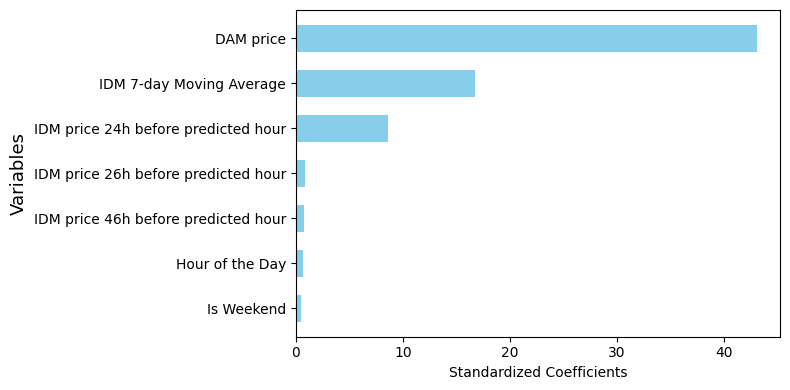

In [57]:
'''Figure 22 - Feature Importance Bar Plot'''

import matplotlib.pyplot as plt
import numpy as np

# Create readable feature names mapping
def get_readable_name(feature):
    if feature == 'DAM price':
        return 'DAM price'
    elif feature.startswith('IDM_lag'):
        lag_num = feature.replace('IDM_lag', '')
        return f'IDM price {lag_num}h before predicted hour'
    elif feature == 'hour':
        return 'Hour of the Day'
    elif feature == 'is_weekend':
        return 'Is Weekend'
    elif feature == 'day_of_week':
        return 'Day of Week'
    elif feature == 'month':
        return 'Month'
    elif feature == 'IDM_ma7':
        return 'IDM 7-day Moving Average'
    elif feature == 'IDM_ma14':
        return 'IDM 14-day Moving Average'
    else:
        return feature

# Extract selected features and their importance
best_selected = best_result['selected_features']
best_coefs = best_result['coefficients']

feature_importance = [
    (get_readable_name(all_features[i]), abs(best_coefs[i]))
    for i in range(len(all_features)) if best_selected[i]
]

# Sort by importance (descending)
feature_importance.sort(key=lambda x: x[1], reverse=True)

# Plot
if feature_importance:
    features, importances = zip(*feature_importance)
    
    fig_height = max(4, len(features) * 0.4)
    plt.figure(figsize=(8, fig_height))
    
    y_pos = np.arange(len(features))
    plt.barh(y_pos, importances, color='skyblue', height=0.6)
    plt.yticks(y_pos, features)
    plt.xlabel('Standardized Coefficients')
    plt.ylabel('Variables', fontsize=13)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("No features selected.")


In [58]:
'''Figure 23 - Autoregressive with LASSO Actual Modelling'''
# h-24 for hours 0-13, h-46 for hours 14-23 + DAM + 7-day MA

import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("Figure 23: HYBRID IDM LAG STRATEGY WITH LASSO")
print("=" * 80)
print("Features: DAM price, Hybrid IDM lag (h-24 for hours 0-13, h-46 for hours 14-23), 7-day MA")
print("=" * 80)

# Load and prepare data
df = pd.read_csv('cleaned_DAM_IDM_data.csv')
df['Date (UK)'] = pd.to_datetime(df['Date (UK)'])
df_filtered = df[(df['Date (UK)'].dt.year >= 2015) & 
                  (df['Date (UK)'].dt.year <= 2024)].sort_values('Date (UK)')

# Create features
df_filtered['hour'] = df_filtered['Date (UK)'].dt.hour
df_filtered['IDM_lag24'] = df_filtered['IDM price'].shift(24)
df_filtered['IDM_lag46'] = df_filtered['IDM price'].shift(46)
df_filtered['IDM_ma7'] = df_filtered['IDM price'].rolling(window=7*24, min_periods=1).mean()

# Hybrid lag: h-24 for hours 0-13, h-46 for hours 14-23
df_filtered['IDM_lag_hybrid'] = np.where(
    df_filtered['hour'] <= 13,
    df_filtered['IDM_lag24'],
    df_filtered['IDM_lag46']
)

df_clean = df_filtered.dropna()

# Train-test split (chronological 80:20)
split_idx = int(len(df_clean) * 0.8)
train, test = df_clean.iloc[:split_idx], df_clean.iloc[split_idx:]

# Prepare and standardize features
feature_names = ['DAM price', 'IDM_lag_hybrid', 'IDM_ma7']
X_train, y_train = train[feature_names].values, train['IDM price'].values
X_test, y_test = test[feature_names].values, test['IDM price'].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nData: {len(train):,} train + {len(test):,} test samples")
print(f"Running LASSO with α = 1 to 10...\n")

# Run LASSO with different alpha values
results = []
for alpha in range(1, 11):
    lasso = Lasso(alpha=alpha, random_state=42, max_iter=5000)
    lasso.fit(X_train_scaled, y_train)
    
    y_train_pred = lasso.predict(X_train_scaled)
    y_test_pred = lasso.predict(X_test_scaled)
    
    results.append({
        'alpha': alpha,
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'n_selected': np.sum(lasso.coef_ != 0),
        'coefficients': lasso.coef_.copy(),
        'selected_features': (lasso.coef_ != 0).copy()
    })

# Summary table
print("=" * 90)
print(f"{'Alpha':<6} {'Selected':<9} {'Train R²':<9} {'Test R²':<8} {'Train RMSE':<11} {'Test RMSE':<10} {'Test MAE':<9}")
print("-" * 90)
for r in results:
    print(f"{r['alpha']:<6} {r['n_selected']:<9} {r['train_r2']:<9.4f} {r['test_r2']:<8.4f} "
          f"{r['train_rmse']:<11.2f} {r['test_rmse']:<10.2f} {r['test_mae']:<9.2f}")
print("=" * 90)

# Best model
best_idx = np.argmax([r['test_r2'] for r in results])
best_result = results[best_idx]
print(f"\nBest Model: α = {best_result['alpha']} | Test R² = {best_result['test_r2']:.4f} | "
      f"Selected {best_result['n_selected']}/{len(feature_names)} features")

# Print model equation in original units
best_lasso = Lasso(alpha=best_result['alpha'], random_state=42, max_iter=5000)
best_lasso.fit(X_train_scaled, y_train)

# Convert standardized coefficients back to original scale
original_coefs = best_lasso.coef_ / scaler.scale_
original_intercept = best_lasso.intercept_ - np.sum(original_coefs * scaler.mean_)

print("\nModel Equation (original units):")
equation_parts = []
for feature, coef in zip(feature_names, original_coefs):
    if abs(coef) > 1e-10:
        equation_parts.append(f"{coef:.4f} × {feature}")
equation = "IDM = " + " + ".join(equation_parts) + f" + {original_intercept:.4f}"
print(f"  {equation}")
print("=" * 80)


Figure 23: HYBRID IDM LAG STRATEGY WITH LASSO
Features: DAM price, Hybrid IDM lag (h-24 for hours 0-13, h-46 for hours 14-23), 7-day MA

Data: 70,084 train + 17,522 test samples
Running LASSO with α = 1 to 10...

Alpha  Selected  Train R²  Test R²  Train RMSE  Test RMSE  Test MAE 
------------------------------------------------------------------------------------------
1      3         0.8546    0.7076   28.21       20.09      13.87    
2      3         0.8540    0.7051   28.27       20.18      13.94    
3      3         0.8530    0.7022   28.36       20.27      14.02    
4      3         0.8516    0.6991   28.50       20.38      14.11    
5      3         0.8497    0.6956   28.68       20.50      14.20    
6      3         0.8475    0.6919   28.89       20.62      14.31    
7      3         0.8449    0.6878   29.14       20.76      14.42    
8      3         0.8418    0.6834   29.42       20.90      14.54    
9      3         0.8384    0.6788   29.74       21.06      14.66    
10    

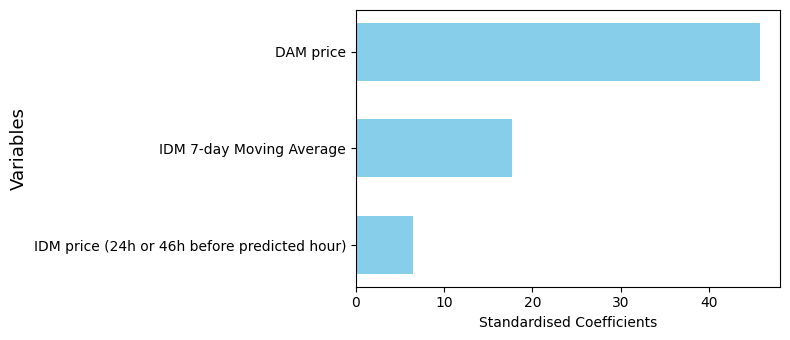

In [59]:
'''Figure 23 - Feature Importance Bar Plot'''

import matplotlib.pyplot as plt
import numpy as np

# Map feature names to readable labels
def get_readable_name(feature):
    name_map = {
        'DAM price': 'DAM price',
        'IDM_lag_hybrid': 'IDM price (24h or 46h before predicted hour)',
        'IDM_ma7': 'IDM 7-day Moving Average'
    }
    return name_map.get(feature, feature)

# Extract selected features and their importance from best model
feature_importance = [
    (get_readable_name(feature_names[i]), abs(best_result['coefficients'][i]))
    for i in range(len(feature_names)) if best_result['selected_features'][i]
]

# Sort by importance (descending)
feature_importance.sort(key=lambda x: x[1], reverse=True)

# Plot
features, importances = zip(*feature_importance)

plt.figure(figsize=(8, 3.5))
y_pos = np.arange(len(features))
plt.barh(y_pos, importances, color='#87CEEB', height=0.6)
plt.yticks(y_pos, features)
plt.xlabel('Standardised Coefficients')
plt.ylabel('Variables', fontsize=13)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
